In [1]:
from kernelforge._fchl19 import flocal_kernel, generate_fchl_acsf, generate_fchl_acsf_and_gradients, flocal_kernel_symm, fatomic_local_gradient_kernel
# import kernelforge
# help(kernelforge._fchl19)
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [32]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
elements=[1, 6, 8]
n_test = 1000
n_train = 500

In [33]:
Y = train["E"][:n_train].flatten()
offset = np.mean(Y)
Y -= offset
Yt = test["E"][:n_test].flatten() - offset

Yft = test["F"][:n_test].flatten()

In [34]:
X = np.asarray([generate_fchl_acsf(r, train["z"], elements=elements) for r in tqdm(train["R"][:n_train])])
dX = np.asarray([generate_fchl_acsf_and_gradients(r, train["z"], elements=elements)[1] for r in tqdm(train["R"][:n_train])])
Q = np.asarray([train["z"] for r in train["R"][:n_train]])
N = np.asarray([len(train["z"]) for r in train["R"][:n_train]])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
Xt = np.asarray([generate_fchl_acsf(r, test["z"], elements=elements) for r in tqdm(test["R"][:n_test])])
dXt = np.asarray([generate_fchl_acsf_and_gradients(r, test["z"], elements=elements)[1] for r in tqdm(test["R"])])
Qt = np.asarray([test["z"] for r in test["R"][:n_test]])
Nt = np.asarray([len(test["z"]) for r in test["R"][:n_test]])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
print(Q.shape)

(500, 9)


In [37]:
sigma = 2
t0 = time.perf_counter()
# K = flocal_kernel_symm(X, Q, N, sigma)
K = flocal_kernel(X, X, Q, Q, N, N, sigma)

t1 = time.perf_counter()
print(t1-t0)

0.07398286901297979


In [38]:
print(K[:5, :5])

[[36.56205673 36.18353264 36.38832142 36.75741247 36.59730816]
 [36.18353264 36.05427466 36.10143915 36.4471952  36.28464488]
 [36.38832142 36.10143915 36.40329634 36.60667564 36.42631773]
 [36.75741247 36.4471952  36.60667564 37.13615363 36.90021563]
 [36.59730816 36.28464488 36.42631773 36.90021563 36.74719399]]


In [39]:
from kernelforge._kernels import solve_cholesky

In [40]:
K_solve = K.copy()
for i in range(K_solve.shape[0]):
    K_solve[i,i] += 1e-8
alphas = solve_cholesky(K_solve, Y)
alphas

array([-7.65709493e+03, -8.67602675e+03, -1.02669233e+05, -7.78255680e+03,
       -2.32087197e+04,  6.48973018e+04,  2.26695057e+04, -2.77572100e+05,
        1.10633526e+04, -7.03311750e+04, -1.60650491e+03,  1.31049810e+05,
       -7.60764243e+04, -7.96671899e+04,  1.31122730e+04, -4.40333490e+04,
       -5.89045527e+03, -9.93559961e+04,  9.55273136e+04, -8.06338542e+04,
        1.37720444e+04,  1.61523523e+04,  3.12207137e+04,  2.61650890e+04,
        6.89683032e+04, -9.58679127e+04,  6.11154754e+04, -1.34186028e+04,
        7.23104314e+04, -1.26991210e+05, -1.12424481e+05,  1.20299428e+05,
        3.48249368e+04, -4.26583232e+04,  2.12007300e+04, -1.71643818e+03,
        1.34672784e+04, -7.66135852e+03, -1.16899756e+05, -6.30967879e+04,
        4.39352954e+04, -1.16775523e+04,  7.35776423e+04, -4.04290598e+04,
        9.49954454e+04, -3.34654173e+04,  7.79029307e+03,  6.85780132e+04,
        2.31328342e+04, -4.09281410e+04,  9.11966409e+04,  6.70752808e+03,
       -2.57537188e+04, -

In [41]:
t0 = time.perf_counter()
Kt = flocal_kernel(Xt, X, Qt, Q, Nt, N, sigma)
t1 = time.perf_counter()
print(t1-t0)

0.11277155898278579


In [42]:
Yp = Kt @ alphas

RMSE = 0.395003292893571
PearsonRResult(statistic=np.float64(0.9965244966194298), pvalue=np.float64(0.0))


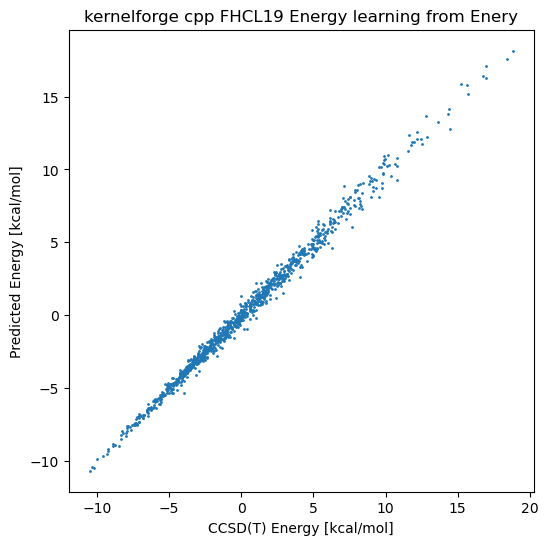

In [43]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yp, Yt)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.title("kernelforge cpp FHCL19 Energy learning from Enery")
plt.scatter(Yt, Yp, s=1)

In [44]:
import os
print(os.environ["LD_PRELOAD"])

/home/andersx/dev/laptop-qml/libfakeintel.so


In [45]:
t0 = time.perf_counter()
Kd = fatomic_local_gradient_kernel(X, Xt, dXt, Q, Qt, N, Nt, sigma).T
t1 = time.perf_counter()
print(t1-t0)

7.247923364018789


In [46]:
Kd.shape

(27000, 500)

In [47]:
Yfp = Kd @ alphas
Yfp.shape

(27000,)

In [48]:
Yft.shape

(27000,)

RMSE = 2.4441422603789538
PearsonRResult(statistic=np.float64(0.9960379323411013), pvalue=np.float64(0.0))


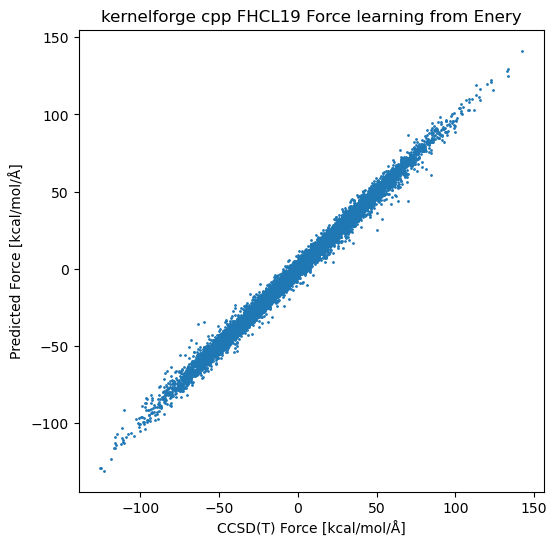

In [49]:
rmse = np.sqrt(np.mean(np.square(Yft - Yfp)))
res = pearsonr(Yfp, Yft)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")
plt.title("kernelforge cpp FHCL19 Force learning from Enery")
plt.scatter(Yft, Yfp, s=1)